# Burst rate summary
This code will extract the mean burst rate during delay of each electrode of each patient and plot a summay figure.

In [1]:
import os
import numpy as np
from ECoGBurst import SpectralBurst
from scipy import stats
from functools import reduce
import matplotlib.pyplot as plt
import copy

In [5]:
# all subjects info
sbj_ls = ['YBG','YBI','YBJ','YBN','YCP']

tone_blk_dict = {
          'YBG' : ['006'],
          'YBI' : ['013'],
          'YBJ' : ['009'],
          'YBN' : ['036'],
          'YCP' : ['035']
          }

recall_blk_dict = {
          'YBG' : ['007','008','009'],
          'YBI' : ['014'],
          'YBJ' : ['010'],
          'YBN' : ['038', '039', '040'],
          'YCP' : ['038', '039']
          }

In [6]:
# home directory
home_path = '~/Documents/MATLAB/ECoG'
home_dir  = os.path.expanduser(home_path)

In [7]:
# initiate all burst object
burst_tone_dict   = {}
burst_recall_dict = {}

for sj in sbj_ls:
    burst_tone_obj   = SpectralBurst(sbj_name = sj, 
                               blk_name = tone_blk_dict[sj], 
                               task_name = 'vis_tone_only')
    burst_recall_obj = SpectralBurst(sbj_name = sj,
                               blk_name = recall_blk_dict[sj],
                               task_name = 'vis_contrast_recall')
    
    burst_tone_dict[sj] = burst_tone_obj
    burst_recall_dict[sj] = burst_recall_obj

In [8]:
# get visual cortex electrodes and responsive electrodes lists for each subject
elec_vis_dict = {}
elec_resp_dict = {}

for sj in sbj_ls:
    burst_tone_obj   = burst_tone_dict[sj]
    burst_recall_obj = burst_recall_dict[sj]
    
    elec_vis_tone    = burst_tone_obj.select_channel()
    elec_vis_recall  = burst_recall_obj.select_channel() 
    
    elec_resp_tone   = burst_tone_obj.select_channel(elec_type = 'resp')
    elec_resp_recall = burst_recall_obj.select_channel(elec_type = 'resp')
    
    elec_vis_select = reduce(np.intersect1d, (elec_vis_tone, elec_vis_recall))
    elec_vis_dict[sj] = elec_vis_select.astype(int).tolist()
    
    elec_resp_select = reduce(np.intersect1d, (elec_resp_tone, elec_resp_recall))
    elec_resp_dict[sj] = elec_resp_select.astype(int).tolist()


In [18]:
def mean_burst_rate(sj,ci,gamma_type):
    '''    
    Get mean burst rate of each electrode of each subject
    
    INPUTs:
    sj : subject name, string
    ci : electrode number, int
    gamma_type: method to get burst event
    
    OUTPUT:
    mean_br_tone_NBG : mean NBG burst rate of vis_tone_only
    mean_br_tone_BBG : mean BBG burst rate of vis_tone_only
    mean_br_recall_NBG : mean NBG burst rate of vis_contrast_recall
    mean_br_recall_BBG : mean BBG burst rate of vis_contrast_recall
    '''
    burst_tone_obj   = burst_tone_dict[sj]
    burst_recall_obj = burst_recall_dict[sj]
    
    NBG_burst_tone,   BBG_burst_tone   = burst_tone_obj.gamma_burst(ci, gamma_type)
    NBG_burst_recall, BBG_burst_recall = burst_recall_obj.gamma_burst(ci, gamma_type)
    
    tone_NBG_burst_rate   = np.mean(NBG_burst_tone, axis = 0)
    tone_BBG_burst_rate   = np.mean(BBG_burst_tone, axis = 0)
    recall_NBG_burst_rate = np.mean(NBG_burst_recall, axis = 0)
    recall_BBG_burst_rate = np.mean(BBG_burst_recall, axis = 0)
    
    # get the mean burst rate during delay
    mean_br_tone_NBG   = np.mean(tone_NBG_burst_rate[3000:6001])
    mean_br_tone_BBG   = np.mean(tone_BBG_burst_rate[3000:6001])
    mean_br_recall_NBG = np.mean(recall_NBG_burst_rate[3000:6001])
    mean_br_recall_BBG = np.mean(recall_BBG_burst_rate[3000:6001])
    
    return mean_br_tone_NBG, mean_br_tone_BBG, mean_br_recall_NBG, mean_br_recall_BBG

In [35]:
# get mean burst rate for each subject in four conditions:
# 1) vis_average: using mean NBG/BBG as gamma, get mean burst rate of all viusal cortex electrodes
# 2) vis_decomp: using decomposed NBG/BBG as gamma, get mbr of all visual cortex electrodes
# 3) resp_average: using mean NBG/BBG, get mbr of all visual responsive electrodes
# 4) resp_decomp: using decomposed NBG/BBG as gamma, get mbr of all visual responsive electrodes

result_tone_NBG_dict = {
    'vis_average': {'YBG':[], 'YBI':[], 'YBJ':[], 'YBN':[], 'YCP':[]},
    'vis_decomp':  {'YBG':[], 'YBI':[], 'YBJ':[], 'YBN':[], 'YCP':[]},
    'resp_average':{'YBG':[], 'YBI':[], 'YBJ':[], 'YBN':[], 'YCP':[]},
    'resp_decomp': {'YBG':[], 'YBI':[], 'YBJ':[], 'YBN':[], 'YCP':[]},
    }
result_tone_BBG_dict   = copy.deepcopy(result_tone_NBG_dict)
result_recall_NBG_dict = copy.deepcopy(result_tone_NBG_dict)
result_recall_BBG_dict = copy.deepcopy(result_tone_NBG_dict)

for sj in sbj_ls:
    
    # loop through visual electrodes
    elec_vis = elec_vis_dict[sj]
    
    for ci in elec_vis:
        mean_br_tone_NBG, mean_br_tone_BBG, mean_br_recall_NBG, mean_br_recall_BBG = mean_burst_rate(sj,ci,'average')
        
        result_tone_NBG_dict['vis_average'][sj].append(mean_br_tone_NBG)
        result_tone_BBG_dict['vis_average'][sj].append(mean_br_tone_BBG)
        result_recall_NBG_dict['vis_average'][sj].append(mean_br_recall_NBG)
        result_recall_BBG_dict['vis_average'][sj].append(mean_br_recall_BBG)
        
        mean_br_tone_NBG2, mean_br_tone_BBG2, mean_br_recall_NBG2, mean_br_recall_BBG2 = mean_burst_rate(sj,ci,'decomp')
        
        result_tone_NBG_dict['vis_decomp'][sj].append(mean_br_tone_NBG2)
        result_tone_BBG_dict['vis_decomp'][sj].append(mean_br_tone_BBG2)
        result_recall_NBG_dict['vis_decomp'][sj].append(mean_br_recall_NBG2)
        result_recall_BBG_dict['vis_decomp'][sj].append(mean_br_recall_BBG2)
        

In [36]:
# extract results of visual responsive electrodes
for sj in sbj_ls:
    elec_vis  = elec_vis_dict[sj]
    elec_resp = elec_resp_dict[sj]
    
    for ci in elec_resp:
        index_ci = elec_vis.index(ci)
        result_tone_NBG_dict['resp_average'][sj].append(result_tone_NBG_dict['vis_average'][sj][index_ci])
        result_tone_BBG_dict['resp_average'][sj].append(result_tone_BBG_dict['vis_average'][sj][index_ci])
        result_recall_NBG_dict['resp_average'][sj].append(result_recall_NBG_dict['vis_average'][sj][index_ci])
        result_recall_BBG_dict['resp_average'][sj].append(result_recall_BBG_dict['vis_average'][sj][index_ci])
        
        result_tone_NBG_dict['resp_decomp'][sj].append(result_tone_NBG_dict['vis_decomp'][sj][index_ci])
        result_tone_BBG_dict['resp_decomp'][sj].append(result_tone_BBG_dict['vis_decomp'][sj][index_ci])
        result_recall_NBG_dict['resp_decomp'][sj].append(result_recall_NBG_dict['vis_decomp'][sj][index_ci])
        result_recall_BBG_dict['resp_decomp'][sj].append(result_recall_BBG_dict['vis_decomp'][sj][index_ci])

With the above codes we have the mean burst rate of all electrodes of all subjects.

## Burst rate summary for each subject

In [57]:
def plot_individual_br(sj):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    plt.subplots_adjust(wspace=0.5)
    plt.setp(axs, ylabel = 'Mean burst rate')
    
    # axs[0,0] and [0,1]: vis electrodes, method = average
    for i in range(len(elec_vis_dict[sj])):
        axs[0,0].scatter(['tone','recall'], [result_tone_NBG_dict['vis_average'][sj][i], result_recall_NBG_dict['vis_average'][sj][i]])
        axs[0,0].plot(   ['tone','recall'], [result_tone_NBG_dict['vis_average'][sj][i], result_recall_NBG_dict['vis_average'][sj][i]])
        
        axs[0,1].scatter(['tone','recall'], [result_tone_BBG_dict['vis_average'][sj][i], result_recall_BBG_dict['vis_average'][sj][i]])
        axs[0,1].plot(   ['tone','recall'], [result_tone_BBG_dict['vis_average'][sj][i], result_recall_BBG_dict['vis_average'][sj][i]])
    
    # axs[0,2] and [0,3]: resp electrodes, method = average
    for i in range(len(elec_resp_dict[sj])):
        axs[0,2].scatter(['tone','recall'], [result_tone_NBG_dict['resp_average'][sj][i], result_recall_NBG_dict['resp_average'][sj][i]])
        axs[0,2].plot(   ['tone','recall'], [result_tone_NBG_dict['resp_average'][sj][i], result_recall_NBG_dict['resp_average'][sj][i]])
        
        axs[0,3].scatter(['tone','recall'], [result_tone_BBG_dict['resp_average'][sj][i], result_recall_BBG_dict['resp_average'][sj][i]])
        axs[0,3].plot(   ['tone','recall'], [result_tone_BBG_dict['resp_average'][sj][i], result_recall_BBG_dict['resp_average'][sj][i]])
    
    # axs[1,0] and [1,1]: vis electrodes, method = decomp
    for i in range(len(elec_vis_dict[sj])):
        axs[1,0].scatter(['tone','recall'], [result_tone_NBG_dict['vis_decomp'][sj][i], result_recall_NBG_dict['vis_decomp'][sj][i]])
        axs[1,0].plot(   ['tone','recall'], [result_tone_NBG_dict['vis_decomp'][sj][i], result_recall_NBG_dict['vis_decomp'][sj][i]])
        
        axs[1,1].scatter(['tone','recall'], [result_tone_BBG_dict['vis_decomp'][sj][i], result_recall_BBG_dict['vis_decomp'][sj][i]])
        axs[1,1].plot(   ['tone','recall'], [result_tone_BBG_dict['vis_decomp'][sj][i], result_recall_BBG_dict['vis_decomp'][sj][i]])
        
    # axs[1,2] and [1,3]: resp electrodes, method = decomp
    for i in range(len(elec_resp_dict[sj])):
        axs[1,2].scatter(['tone','recall'], [result_tone_NBG_dict['resp_decomp'][sj][i], result_recall_NBG_dict['resp_decomp'][sj][i]])
        axs[1,2].plot(   ['tone','recall'], [result_tone_NBG_dict['resp_decomp'][sj][i], result_recall_NBG_dict['resp_decomp'][sj][i]])
        
        axs[1,3].scatter(['tone','recall'], [result_tone_BBG_dict['resp_decomp'][sj][i], result_recall_BBG_dict['resp_decomp'][sj][i]])
        axs[1,3].plot(   ['tone','recall'], [result_tone_BBG_dict['resp_decomp'][sj][i], result_recall_BBG_dict['resp_decomp'][sj][i]])
    
    axs[0,0].set_title('NBG_vis_old')
    axs[0,1].set_title('BBG_vis_old')
    
    axs[0,2].set_title('NBG_resp_old')
    axs[0,3].set_title('BBG_resp_old')
    
    axs[1,0].set_title('NBG_vis_decomp')
    axs[1,1].set_title('BBG_vis_decomp')
    
    axs[1,2].set_title('NBG_resp_decomp')
    axs[1,3].set_title('BBG_resp_decomp')
    title_text = 'Mean burst rate of ' + sj
    fig.suptitle(title_text, fontsize=16)

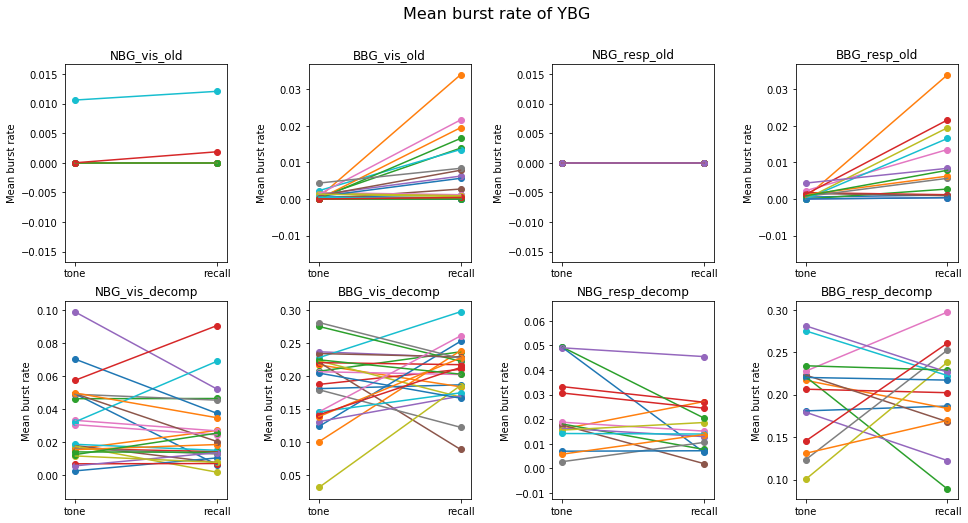

In [58]:
plot_individual_br('YBG')

### YBG 
To read the figure:

The **1st row** used the **old method** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.  

The **2nd row** used the **direct decomposition** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**. 

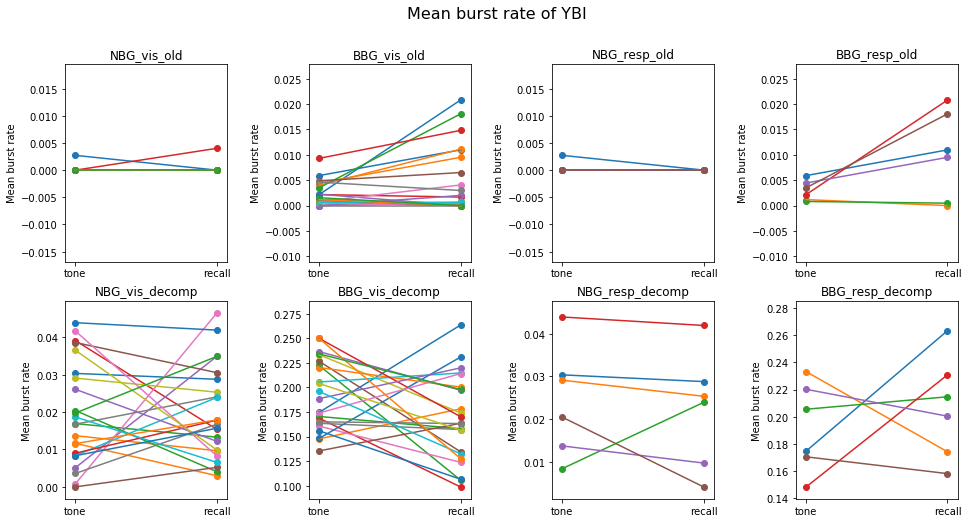

In [60]:
plot_individual_br('YBI')

## YBI
To read the figure:

The **1st row** used the **old method** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.  

The **2nd row** used the **direct decomposition** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**. 

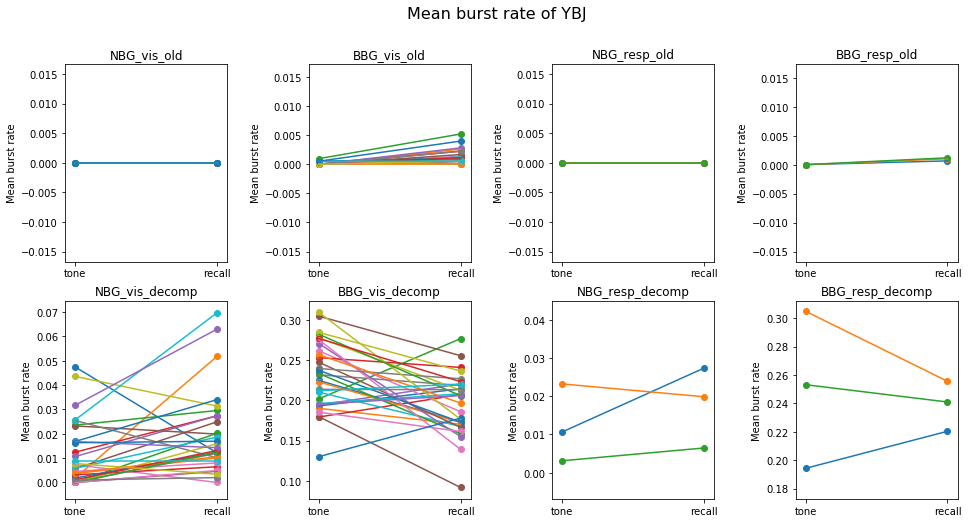

In [61]:
plot_individual_br('YBJ')

### YBJ
To read the figure:

The **1st row** used the **old method** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.  

The **2nd row** used the **direct decomposition** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**. 

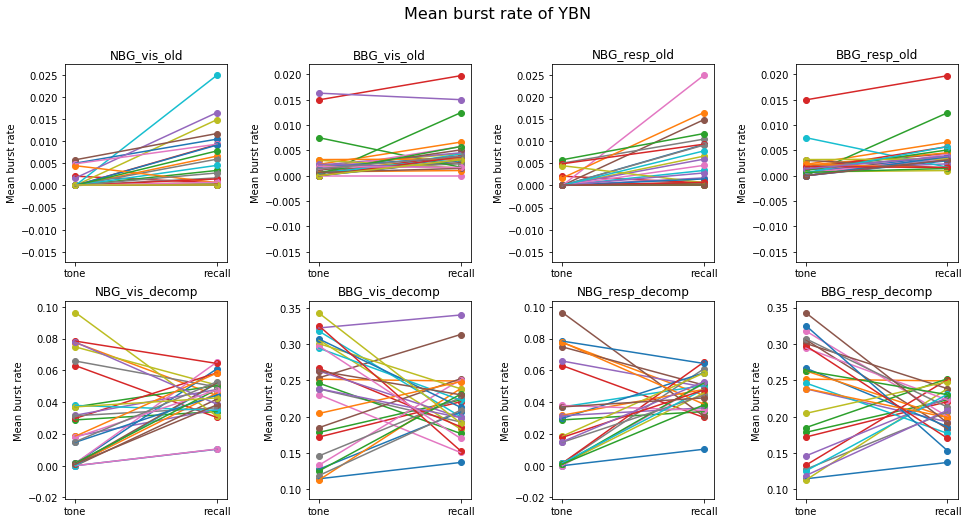

In [62]:
plot_individual_br('YBN')

### YBN 
To read the figure:

The **1st row** used the **old method** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.  

The **2nd row** used the **direct decomposition** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.

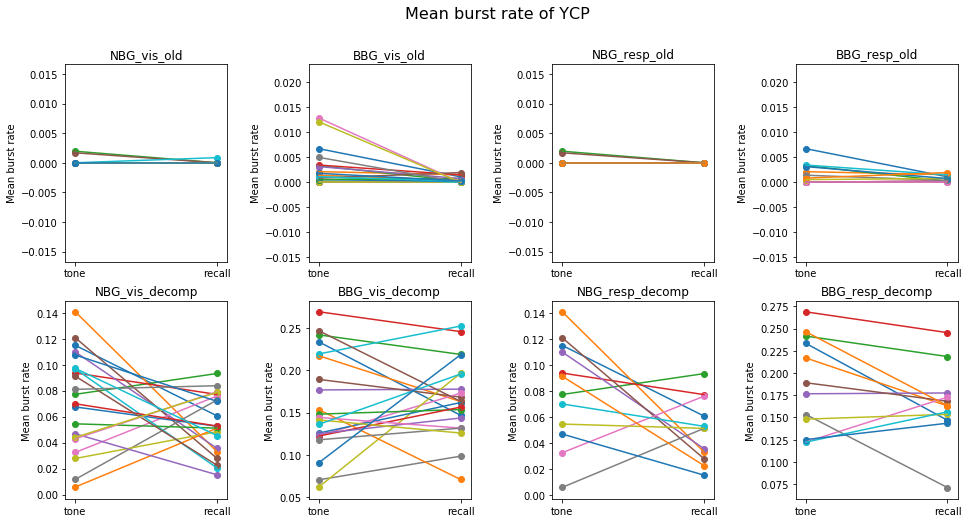

In [63]:
plot_individual_br('YCP')

### YCP 
To read the figure:

The **1st row** used the **old method** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.  

The **2nd row** used the **direct decomposition** to get gamma activity, the **left two** plots the **visual cortex electrodes ('vis')**, the **right rwo** plots the **visual responsive electrodes ('resp')**.

## Combine all the subject together
The electrodes from a given subject are using the same color.

First, plot the **NBG** burst rates together.

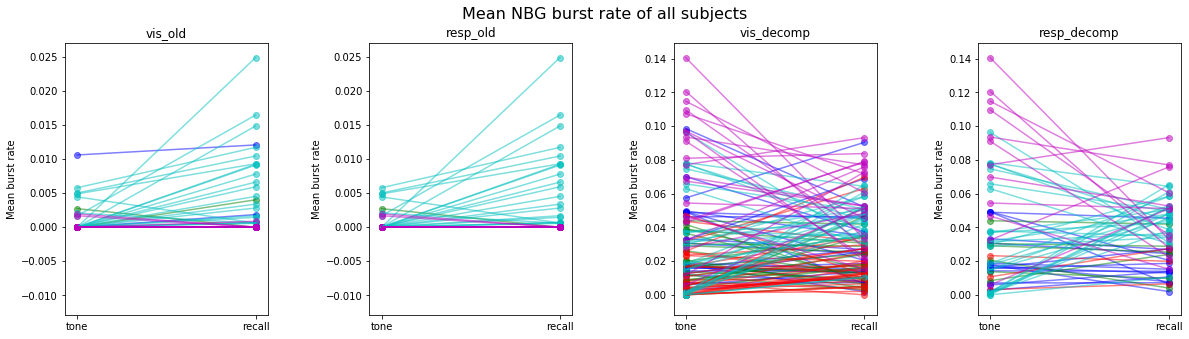

In [70]:
fig, axs = plt.subplots(1,4, figsize = (20,5))
plt.subplots_adjust(wspace=0.5)
plt.setp(axs, ylabel = 'Mean burst rate')

color_code = ['b', 'g', 'r', 'c', 'm']

color_index = 0
for sj in sbj_ls:
       
    for i in range(len(elec_vis_dict[sj])):
        axs[0].scatter(['tone','recall'], [result_tone_NBG_dict['vis_average'][sj][i], 
                                           result_recall_NBG_dict['vis_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[0].plot(   ['tone','recall'], [result_tone_NBG_dict['vis_average'][sj][i], 
                                           result_recall_NBG_dict['vis_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[2].scatter(['tone','recall'], [result_tone_NBG_dict['vis_decomp'][sj][i], 
                                           result_recall_NBG_dict['vis_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[2].plot(   ['tone','recall'], [result_tone_NBG_dict['vis_decomp'][sj][i], 
                                           result_recall_NBG_dict['vis_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
    
    for i in range(len(elec_resp_dict[sj])):
        axs[1].scatter(['tone','recall'], [result_tone_NBG_dict['resp_average'][sj][i], 
                                           result_recall_NBG_dict['resp_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[1].plot(   ['tone','recall'], [result_tone_NBG_dict['resp_average'][sj][i], 
                                           result_recall_NBG_dict['resp_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[3].scatter(['tone','recall'], [result_tone_NBG_dict['resp_decomp'][sj][i], 
                                           result_recall_NBG_dict['resp_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[3].plot(   ['tone','recall'], [result_tone_NBG_dict['resp_decomp'][sj][i], 
                                           result_recall_NBG_dict['resp_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
    axs[0].set_title('vis_old')
    axs[1].set_title('resp_old')
    axs[2].set_title('vis_decomp')
    axs[3].set_title('resp_decomp')
    
    title_text = 'Mean NBG burst rate of all subjects'
    fig.suptitle(title_text, fontsize=16)
    
    color_index += 1

From left to right:
* Used **old method** to get gamma activity, **visual cortex** electrodes
* Used **old method** to get gamma activity, **visual responsive** electrodes
* Used **direct decomposition** to get gamma activity, **visual cortex** electrodes
* Used **direct decomposition** to get gamma activity, **visual responsive** electrodes

Then, plot the **BBG** burst rate together

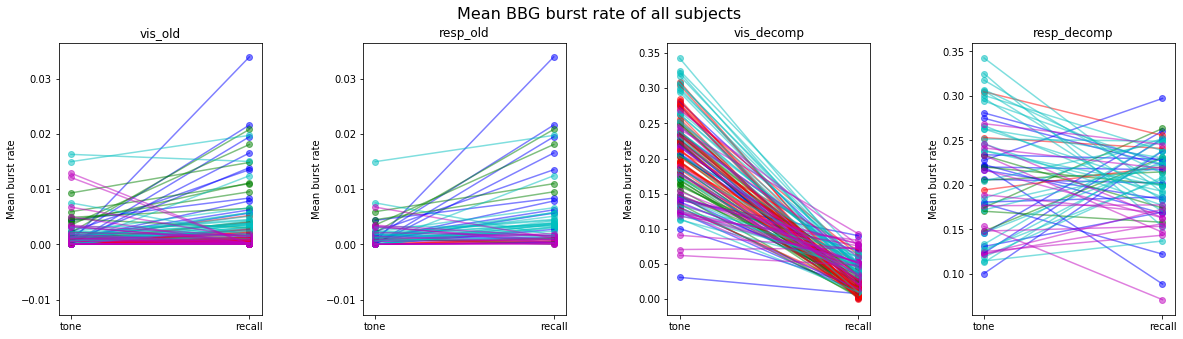

In [71]:
fig, axs = plt.subplots(1,4, figsize = (20,5))
plt.subplots_adjust(wspace=0.5)
plt.setp(axs, ylabel = 'Mean burst rate')

color_code = ['b', 'g', 'r', 'c', 'm']

color_index = 0
for sj in sbj_ls:
       
    for i in range(len(elec_vis_dict[sj])):
        axs[0].scatter(['tone','recall'], [result_tone_BBG_dict['vis_average'][sj][i], 
                                           result_recall_BBG_dict['vis_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[0].plot(   ['tone','recall'], [result_tone_BBG_dict['vis_average'][sj][i], 
                                           result_recall_BBG_dict['vis_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[2].scatter(['tone','recall'], [result_tone_BBG_dict['vis_decomp'][sj][i], 
                                           result_recall_NBG_dict['vis_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[2].plot(   ['tone','recall'], [result_tone_BBG_dict['vis_decomp'][sj][i], 
                                           result_recall_NBG_dict['vis_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
    
    for i in range(len(elec_resp_dict[sj])):
        axs[1].scatter(['tone','recall'], [result_tone_BBG_dict['resp_average'][sj][i], 
                                           result_recall_BBG_dict['resp_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[1].plot(   ['tone','recall'], [result_tone_BBG_dict['resp_average'][sj][i], 
                                           result_recall_BBG_dict['resp_average'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[3].scatter(['tone','recall'], [result_tone_BBG_dict['resp_decomp'][sj][i], 
                                           result_recall_BBG_dict['resp_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
        axs[3].plot(   ['tone','recall'], [result_tone_BBG_dict['resp_decomp'][sj][i], 
                                           result_recall_BBG_dict['resp_decomp'][sj][i]], 
                                           c = color_code[color_index], alpha = 0.5)
    axs[0].set_title('vis_old')
    axs[1].set_title('resp_old')
    axs[2].set_title('vis_decomp')
    axs[3].set_title('resp_decomp')
    
    title_text = 'Mean BBG burst rate of all subjects'
    fig.suptitle(title_text, fontsize=16)
    
    color_index += 1

From left to right:
* Used **old method** to get gamma activity, **visual cortex** electrodes
* Used **old method** to get gamma activity, **visual responsive** electrodes
* Used **direct decomposition** to get gamma activity, **visual cortex** electrodes
* Used **direct decomposition** to get gamma activity, **visual responsive** electrodes